# Load Packages

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import MultiPolygon

In [ ]:
#DB CONNECTION

import psycopg2
from psycopg2 import sql
from psycopg2.extensions import adapt, register_adapter, AsIs
from sqlalchemy import create_engine,text
import getpass
import re
from sklearn.preprocessing import normalize

#DB connection string
database = 'f24t03'
user = 'jsmm8'
mypasswd = getpass.getpass("Type password and hit enter: ")

Type password and hit enter: ········


In [106]:
!pip install rtree

# Read Sinkholes Shapefiles prepared from QGIS

In [82]:

# Load the parcel sinkhole intersection layer and parcel home join layer

snkhole_pcl_intersection = gpd.read_file("sinkhole_parcel_intersection.shp")  
pcl_home_join_file = gpd.read_file("parcel_home_join.shp") 

# Reproject both to EPSG:29615
snkhole_pcl_intersection = snkhole_pcl_intersection.to_crs(epsg=26915)
pcl_home_join_file = pcl_home_join_file.to_crs(epsg=26915)

# Check result crs
print(snkhole_pcl_intersection.crs)
print(pcl_home_join_file.crs)

#check sample of parcel intersection 
snkhole_pcl_intersection.head()

{'init': 'epsg:26915', 'no_defs': True}
{'init': 'epsg:26915', 'no_defs': True}


,FID,area_sq_m,OBJECTID_1,Join_Count,TARGET_FID,OBJECTID,PRIM_NUM,SUB_NUM,PRE_DIR,STR_NAM,...,_range,_minority,_majority,_variety,_variance,area_sqm,inter_area,sh_pcl_pct,ploccshpct,geometry
0,7788,939.218,336.0,1.0,391.0,64908.0,5435,None,S,JEFFERSON,...,2.0,6.0,8.0,2.0,0.437500,2698.861,303.872,11.20,32,"POLYGON ((473957.741 4107745.498, 473957.697 4..."
1,7789,933.370,338.0,1.0,393.0,64907.0,5423,None,S,JEFFERSON,...,2.0,6.0,8.0,2.0,0.437500,2698.861,741.115,27.40,79,"POLYGON ((473919.472 4107746.577, 473920.230 4..."
2,8080,1076.870,339.0,1.0,395.0,93510.0,5411,None,S,JEFFERSON,...,2.0,6.0,8.0,2.0,0.437500,2698.861,226.977,8.41,21,"POLYGON ((473920.230 4107770.804, 473920.653 4..."
3,12015,1404.982,438.0,1.0,504.0,18438.0,5201,None,S,HAZEL,...,5.0,3.0,6.0,3.0,3.614499,39.038,34.585,88.50,2,"POLYGON ((474690.452 4108191.701, 474690.308 4..."
4,8066,1640.390,456.0,1.0,522.0,36758.0,5189,None,S,HAZEL,...,5.0,3.0,6.0,3.0,3.614499,39.038,4.454,11.40,0,"POLYGON ((474687.143 4108195.861, 474687.577 4..."


In [83]:
#check sample of parcel home join 
pcl_home_join_file.head()

,FID,area_sq_m,OBJECTID_1,Join_Count,TARGET_FID,OBJECTID,PRIM_NUM,SUB_NUM,PRE_DIR,STR_NAM,...,near_flood,near_sinkh,near_n_org,near_n_ser,near_eleme,near_middl,near_high,near_early,has_house,geometry
0,12183,984.622,1.0,1.0,1.0,4376.0,6525,None,S,MEADOWVIEW,...,0.0,47.599777,3658.547119,0.0,6134.605469,6107.382324,7539.026367,14466.401367,Y,"POLYGON ((479707.616 4105432.438, 479723.923 4..."
1,12182,1334.756,2.0,1.0,2.0,18394.0,6519,None,S,MEADOWVIEW,...,0.0,74.962669,3646.280273,0.0,6123.302734,6076.045410,7528.901367,14454.065430,Y,"POLYGON ((479723.923 4105465.231, 479707.616 4..."
2,1304,1040.205,4.0,1.0,5.0,79507.0,6513,None,S,MEADOWVIEW,...,0.0,100.858406,3612.993896,0.0,6089.995117,6062.061523,7495.614746,14420.786133,Y,"POLYGON ((479681.803 4105476.963, 479681.205 4..."
3,5307,1419.165,6.0,1.0,7.0,36663.0,6505,None,S,MEADOWVIEW,...,0.0,120.320229,3589.622559,0.0,6066.541992,6054.200195,7472.093262,14397.428711,Y,"POLYGON ((479668.959 4105526.122, 479731.847 4..."
4,585,1014.484,10.0,1.0,12.0,27522.0,3454,None,E,LADUE,...,0.0,166.543015,3535.674072,0.0,6011.944336,6048.275391,7416.798828,14343.529297,Y,"POLYGON ((479733.394 4105580.420, 479732.530 4..."


In [84]:
#check structure of parcel home join 
pcl_home_join_file.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 89460 entries, 0 to 89459
Data columns (total 65 columns):
FID           89460 non-null int64
area_sq_m     89460 non-null float64
OBJECTID_1    43187 non-null float64
Join_Count    43187 non-null float64
TARGET_FID    43187 non-null float64
OBJECTID      43187 non-null float64
PRIM_NUM      43187 non-null object
SUB_NUM       4 non-null object
PRE_DIR       43187 non-null object
STR_NAM       43187 non-null object
STR_TYPE      43184 non-null object
CITY          43187 non-null object
STATE         43187 non-null object
ZIP5          43187 non-null object
ADDRESS       43187 non-null object
BLOCK         43187 non-null object
NSA           43187 non-null object
BDS_ZONE      43187 non-null object
ZONING        43187 non-null object
PD_NUM        43187 non-null float64
OBJECTID_2    43187 non-null float64
PRIM_NUM_1    0 non-null object
SUB_NUM_1     0 non-null object
PRE_DIR_1     0 non-null object
STR_NAM_1     0 non-null obje

In [85]:
#check structure of parcel sinkhole intersection  
snkhole_pcl_intersection.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2013 entries, 0 to 2012
Data columns (total 91 columns):
FID           2013 non-null int64
area_sq_m     2013 non-null float64
OBJECTID_1    908 non-null float64
Join_Count    908 non-null float64
TARGET_FID    908 non-null float64
OBJECTID      908 non-null float64
PRIM_NUM      908 non-null object
SUB_NUM       0 non-null object
PRE_DIR       908 non-null object
STR_NAM       908 non-null object
STR_TYPE      907 non-null object
CITY          908 non-null object
STATE         908 non-null object
ZIP5          908 non-null object
ADDRESS       908 non-null object
BLOCK         908 non-null object
NSA           908 non-null object
BDS_ZONE      908 non-null object
ZONING        908 non-null object
PD_NUM        908 non-null float64
OBJECTID_2    908 non-null float64
PRIM_NUM_1    0 non-null object
SUB_NUM_1     0 non-null object
PRE_DIR_1     0 non-null object
STR_NAM_1     0 non-null object
STR_TYPE_1    0 non-null object
CITY_

# Data Shaping and Carpentry

In [86]:
#drop na records to make sure the dataset is containing records which are not null in all columns
snkhole_pcl_intersection = snkhole_pcl_intersection.dropna(axis=1, how='all')

# Verify remaining columns
print(snkhole_pcl_intersection.columns)

Index(['FID', 'area_sq_m', 'OBJECTID_1', 'Join_Count', 'TARGET_FID',
       'OBJECTID', 'PRIM_NUM', 'PRE_DIR', 'STR_NAM', 'STR_TYPE', 'CITY',
       'STATE', 'ZIP5', 'ADDRESS', 'BLOCK', 'NSA', 'BDS_ZONE', 'ZONING',
       'PD_NUM', 'OBJECTID_2', 'PD_NUM_1', 'verify', 'ORIG_FID', 'near_polic',
       'near_fire', 'near_bike_', 'near_share', 'near_signe', 'near_sig_1',
       'near_paved', 'near_unpav', 'near_water', 'near_aspha', 'near_grave',
       'near_natur', 'NEAR_FID', 'NEAR_DIST', 'near_bik_1', 'near_green',
       'near_park_', 'near_parks', 'near_flood', 'near_sinkh', 'near_n_org',
       'near_n_ser', 'near_eleme', 'near_middl', 'near_high', 'near_early',
       'has_house', 'OBJECTID_3', 'OBJECTID_4', 'SEC', 'TWP', 'RNG',
       'LENGTH_FT', 'WIDTH_FT', 'SOURCE', 'Shape_Leng', 'Shape_Area', '_count',
       '_sum', '_mean', '_median', '_stdev', '_min', '_max', '_range',
       '_minority', '_majority', '_variety', '_variance', 'area_sqm',
       'inter_area', 'sh_pcl_pct', '

In [87]:
# Filter rows where 'has_house' is 'Y'
snkhole_pcl_intersection = snkhole_pcl_intersection[snkhole_pcl_intersection['has_house'] == 'Y']

# Verify the filtered dataset
print(snkhole_pcl_intersection.shape)
print(snkhole_pcl_intersection['has_house'].unique())  # Should show only 'Y'

(908, 77)
['Y']


In [88]:
#check sample
snkhole_pcl_intersection.head()

,FID,area_sq_m,OBJECTID_1,Join_Count,TARGET_FID,OBJECTID,PRIM_NUM,PRE_DIR,STR_NAM,STR_TYPE,...,_range,_minority,_majority,_variety,_variance,area_sqm,inter_area,sh_pcl_pct,ploccshpct,geometry
0,7788,939.218,336.0,1.0,391.0,64908.0,5435,S,JEFFERSON,AVE,...,2.0,6.0,8.0,2.0,0.437500,2698.861,303.872,11.20,32,"POLYGON ((473957.741 4107745.498, 473957.697 4..."
1,7789,933.370,338.0,1.0,393.0,64907.0,5423,S,JEFFERSON,AVE,...,2.0,6.0,8.0,2.0,0.437500,2698.861,741.115,27.40,79,"POLYGON ((473919.472 4107746.577, 473920.230 4..."
2,8080,1076.870,339.0,1.0,395.0,93510.0,5411,S,JEFFERSON,AVE,...,2.0,6.0,8.0,2.0,0.437500,2698.861,226.977,8.41,21,"POLYGON ((473920.230 4107770.804, 473920.653 4..."
3,12015,1404.982,438.0,1.0,504.0,18438.0,5201,S,HAZEL,DR,...,5.0,3.0,6.0,3.0,3.614499,39.038,34.585,88.50,2,"POLYGON ((474690.452 4108191.701, 474690.308 4..."
4,8066,1640.390,456.0,1.0,522.0,36758.0,5189,S,HAZEL,DR,...,5.0,3.0,6.0,3.0,3.614499,39.038,4.454,11.40,0,"POLYGON ((474687.143 4108195.861, 474687.577 4..."


In [90]:
#check shape
pcl_home_join_file.shape

(89460, 65)

In [92]:
# Performing a left join on OBJECTID and merge both datasets
result = pd.merge(pcl_home_join_file, 
                  snkhole_pcl_intersection[['OBJECTID', 'inter_area', 'sh_pcl_pct', 'ploccshpct']], 
                  on='OBJECTID', 
                  how='left')

# Displaying the result shape
print(result.shape)


(89486, 68)


In [93]:
#check sample
result.head()

,FID,area_sq_m,OBJECTID_1,Join_Count,TARGET_FID,OBJECTID,PRIM_NUM,SUB_NUM,PRE_DIR,STR_NAM,...,near_n_ser,near_eleme,near_middl,near_high,near_early,has_house,geometry,inter_area,sh_pcl_pct,ploccshpct
0,12183,984.622,1.0,1.0,1.0,4376.0,6525,None,S,MEADOWVIEW,...,0.0,6134.605469,6107.382324,7539.026367,14466.401367,Y,"POLYGON ((479707.616 4105432.438, 479723.923 4...",NaN,NaN,NaN
1,12182,1334.756,2.0,1.0,2.0,18394.0,6519,None,S,MEADOWVIEW,...,0.0,6123.302734,6076.045410,7528.901367,14454.065430,Y,"POLYGON ((479723.923 4105465.231, 479707.616 4...",NaN,NaN,NaN
2,1304,1040.205,4.0,1.0,5.0,79507.0,6513,None,S,MEADOWVIEW,...,0.0,6089.995117,6062.061523,7495.614746,14420.786133,Y,"POLYGON ((479681.803 4105476.963, 479681.205 4...",NaN,NaN,NaN
3,5307,1419.165,6.0,1.0,7.0,36663.0,6505,None,S,MEADOWVIEW,...,0.0,6066.541992,6054.200195,7472.093262,14397.428711,Y,"POLYGON ((479668.959 4105526.122, 479731.847 4...",NaN,NaN,NaN
4,585,1014.484,10.0,1.0,12.0,27522.0,3454,None,E,LADUE,...,0.0,6011.944336,6048.275391,7416.798828,14343.529297,Y,"POLYGON ((479733.394 4105580.420, 479732.530 4...",NaN,NaN,NaN


In [94]:
#create risk measure function
def assign_risk(row):
    if row['has_house'] != 'Y':
        return 0
    pct = row['ploccshpct']
    if pct >= 90 and pct == 100:
        return 5
    elif pct >= 50 and pct <= 89:
        return 4
    elif pct >= 25 and pct <= 49:
        return 3
    elif pct >= 10 and pct <= 24:
        return 2
    elif pct > 0 and pct <= 9:
        return 1
    else:
        return 0

# Apply the function to each row
result['sinkhole_house_risk_rating'] = result.apply(assign_risk, axis=1)


In [96]:
#check sample
result.head()

,FID,area_sq_m,OBJECTID_1,Join_Count,TARGET_FID,OBJECTID,PRIM_NUM,SUB_NUM,PRE_DIR,STR_NAM,...,near_eleme,near_middl,near_high,near_early,has_house,geometry,inter_area,sh_pcl_pct,ploccshpct,sinkhole_house_risk_rating
0,12183,984.622,1.0,1.0,1.0,4376.0,6525,None,S,MEADOWVIEW,...,6134.605469,6107.382324,7539.026367,14466.401367,Y,"POLYGON ((479707.616 4105432.438, 479723.923 4...",NaN,NaN,NaN,0
1,12182,1334.756,2.0,1.0,2.0,18394.0,6519,None,S,MEADOWVIEW,...,6123.302734,6076.045410,7528.901367,14454.065430,Y,"POLYGON ((479723.923 4105465.231, 479707.616 4...",NaN,NaN,NaN,0
2,1304,1040.205,4.0,1.0,5.0,79507.0,6513,None,S,MEADOWVIEW,...,6089.995117,6062.061523,7495.614746,14420.786133,Y,"POLYGON ((479681.803 4105476.963, 479681.205 4...",NaN,NaN,NaN,0
3,5307,1419.165,6.0,1.0,7.0,36663.0,6505,None,S,MEADOWVIEW,...,6066.541992,6054.200195,7472.093262,14397.428711,Y,"POLYGON ((479668.959 4105526.122, 479731.847 4...",NaN,NaN,NaN,0
4,585,1014.484,10.0,1.0,12.0,27522.0,3454,None,E,LADUE,...,6011.944336,6048.275391,7416.798828,14343.529297,Y,"POLYGON ((479733.394 4105580.420, 479732.530 4...",NaN,NaN,NaN,0


# EDA & Feature Engineering

In [97]:
# Get the counts of unique values in the 'Sinkhole_House_Risk_Rating' column
riskrating_counts = result['sinkhole_house_risk_rating'].value_counts()

# Display the counts
print(riskrating_counts)


0    88750
1      263
2      126
3      119
5      114
4      114
Name: sinkhole_house_risk_rating, dtype: int64


In [98]:
# Filter the data where Sinkhole_House_Risk_Rating is 5
filtered_data = result[result['sinkhole_house_risk_rating'] != 0]

#  summary statistics for 'inter_area', 'sh_pcl_pct', 'ploccshpct'
stats = filtered_data[['inter_area', 'sh_pcl_pct', 'ploccshpct']].describe()

# Display the stats
print(stats)

         inter_area  sh_pcl_pct  ploccshpct
count    736.000000  736.000000  736.000000
mean     479.948958   18.732853   35.703804
std      825.792829   30.433955   35.420265
min        2.921000    0.010000    1.000000
25%       55.184250    1.160000    5.000000
50%      227.672000    3.460000   23.000000
75%      678.562750   19.750000   60.250000
max    12422.993000  100.000000  100.000000


In [99]:
#check columns
result.columns

Index(['FID', 'area_sq_m', 'OBJECTID_1', 'Join_Count', 'TARGET_FID',
       'OBJECTID', 'PRIM_NUM', 'SUB_NUM', 'PRE_DIR', 'STR_NAM', 'STR_TYPE',
       'CITY', 'STATE', 'ZIP5', 'ADDRESS', 'BLOCK', 'NSA', 'BDS_ZONE',
       'ZONING', 'PD_NUM', 'OBJECTID_2', 'PRIM_NUM_1', 'SUB_NUM_1',
       'PRE_DIR_1', 'STR_NAM_1', 'STR_TYPE_1', 'CITY_1', 'STATE_1', 'ZIP5_1',
       'ADDRESS_1', 'BLOCK_1', 'NSA_1', 'BDS_ZONE_1', 'ZONING_1', 'PD_NUM_1',
       'verify', 'ORIG_FID', 'near_polic', 'near_fire', 'near_bike_',
       'near_share', 'near_signe', 'near_sig_1', 'near_paved', 'near_unpav',
       'near_water', 'near_aspha', 'near_grave', 'near_natur', 'NEAR_FID',
       'NEAR_DIST', 'near_bik_1', 'near_green', 'near_park_', 'near_parks',
       'near_flood', 'near_sinkh', 'near_n_org', 'near_n_ser', 'near_eleme',
       'near_middl', 'near_high', 'near_early', 'has_house', 'geometry',
       'inter_area', 'sh_pcl_pct', 'ploccshpct', 'sinkhole_house_risk_rating'],
      dtype='object')

In [101]:


#Create the connection and extract data from 'springfield_neighborhood_service_areas' table
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql.dsa.lan',
                            password=mypasswd)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# Define the query to select all data from the springfield_neighborhood_service_areas table
query = "SELECT * FROM springfield_neighborhood_service_areas;"

try:
    nsa = gpd.read_postgis(query, conn, geom_col='geom')
    print("Data extracted successfully!")
except Exception as e:
    print("Error extracting data:", e)
finally:
    # Close the connection
    conn.close()

# Display the DataFrame
print(nsa.shape)
#sample 
nsa.head()

Type password and hit enter: ········
I am able to connect to the database
Data extracted successfully!
(38, 7)


,objectid_1,name,shapestare,shapestlen,shape_length,shape_area,geom
0,1,Grant Beach,3.107893e+07,22403.823703,6826.057182,2.885105e+06,"MULTIPOLYGON (((474089.118 4120469.519, 474088..."
1,2,Oak Grove,5.694040e+07,32119.505522,9786.311928,5.285924e+06,"MULTIPOLYGON (((480052.310 4114905.475, 480052..."
2,3,Midtown,2.839690e+07,21373.071458,6512.016504,2.636137e+06,"MULTIPOLYGON (((475419.924 4118741.896, 475052..."
3,4,Weller,2.558836e+07,20759.618765,6325.117077,2.375422e+06,"MULTIPOLYGON (((476778.203 4118815.866, 476776..."
4,5,Woodland Heights,2.922756e+07,23012.009407,7011.363483,2.713241e+06,"MULTIPOLYGON (((472934.565 4120381.619, 472883..."


No handles with labels found to put in legend.


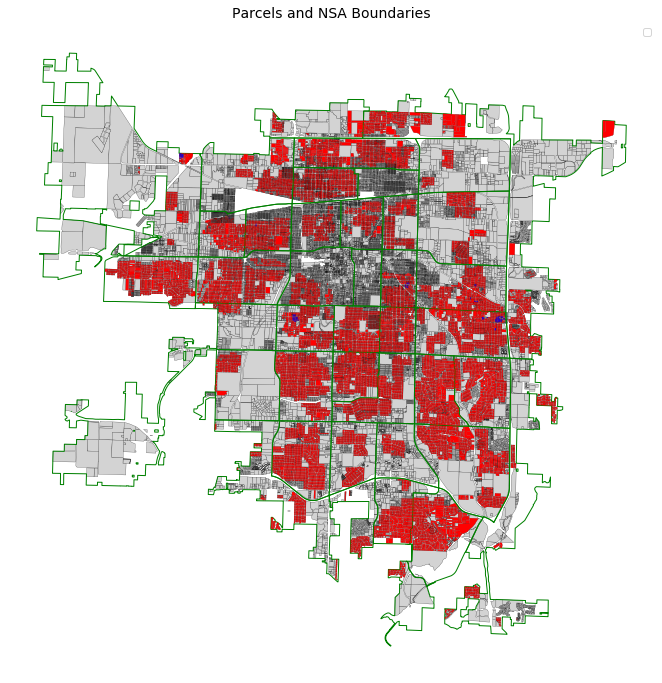

In [102]:
# Overlay NSA boundaries on parcel data
fig, ax = plt.subplots(figsize=(12, 12))

# Plot parcels
result.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.2)

# Plot NSA boundaries on top
nsa.plot(ax=ax, color='none', edgecolor='green', linewidth=1, label='NSA Boundaries')
# Highlight parcels with houses in red
result[result['has_house'] == 'Y'].plot(ax=ax, color='red', edgecolor='black', linewidth=0.02, label='Has House')

# Highlight parcels with Sinkhole_House_Risk_Rating == 5 in blue
result[result['sinkhole_house_risk_rating'] == 5].plot(ax=ax, color='blue', edgecolor='black', linewidth=0.02, label='Risk Rating 100')

# Final touches
ax.set_title("Parcels and NSA Boundaries", fontsize=14)
ax.axis('off')
ax.legend()

plt.show()


In [103]:
# Add the 'has_sinkhole_impact' column based on Sinkhole_House_Risk_Rating
result['has_sinkhole_impact'] = result['sinkhole_house_risk_rating'].apply(lambda x: 'Y' if x != 0 else 'N')
#check sample
result.head()

,FID,area_sq_m,OBJECTID_1,Join_Count,TARGET_FID,OBJECTID,PRIM_NUM,SUB_NUM,PRE_DIR,STR_NAM,...,near_middl,near_high,near_early,has_house,geometry,inter_area,sh_pcl_pct,ploccshpct,sinkhole_house_risk_rating,has_sinkhole_impact
0,12183,984.622,1.0,1.0,1.0,4376.0,6525,None,S,MEADOWVIEW,...,6107.382324,7539.026367,14466.401367,Y,"POLYGON ((479707.616 4105432.438, 479723.923 4...",NaN,NaN,NaN,0,N
1,12182,1334.756,2.0,1.0,2.0,18394.0,6519,None,S,MEADOWVIEW,...,6076.045410,7528.901367,14454.065430,Y,"POLYGON ((479723.923 4105465.231, 479707.616 4...",NaN,NaN,NaN,0,N
2,1304,1040.205,4.0,1.0,5.0,79507.0,6513,None,S,MEADOWVIEW,...,6062.061523,7495.614746,14420.786133,Y,"POLYGON ((479681.803 4105476.963, 479681.205 4...",NaN,NaN,NaN,0,N
3,5307,1419.165,6.0,1.0,7.0,36663.0,6505,None,S,MEADOWVIEW,...,6054.200195,7472.093262,14397.428711,Y,"POLYGON ((479668.959 4105526.122, 479731.847 4...",NaN,NaN,NaN,0,N
4,585,1014.484,10.0,1.0,12.0,27522.0,3454,None,E,LADUE,...,6048.275391,7416.798828,14343.529297,Y,"POLYGON ((479733.394 4105580.420, 479732.530 4...",NaN,NaN,NaN,0,N


In [105]:
# Load the sinkhole layer
sinkholes = gpd.read_file("sinkhole_stats_2024_within_city.shp")
#convert crs
sinkholes = sinkholes.to_crs(epsg=26915)
#check crs
print(sinkholes.crs)
print(sinkholes.geom_type.unique())


{'init': 'epsg:26915', 'no_defs': True}
['Polygon' 'MultiPolygon']


In [107]:
# Check null geometries in result
null_geom_result = result[result.geometry.isnull()]
print(f"Null geometries in result: {len(null_geom_result)}")

# Check null geometries in sinkholes
null_geom_sinkholes = sinkholes[sinkholes.geometry.isnull()]
print(f"Null geometries in sinkholes: {len(null_geom_sinkholes)}")


Null geometries in result: 0
Null geometries in sinkholes: 0


In [108]:
# Only check for parcels with house and ploccshpct == 0
no_impact = result[(result['ploccshpct'] == 0) & (result['has_house'] == 'Y')].copy()

# Buffer by 10 meters
no_impact['geometry'] = no_impact.geometry.buffer(10)

# Manual check: mark parcels that intersect any sinkhole
def has_nearby_sinkhole(parcel_geom, sinkhole_geoms):
    return sinkhole_geoms.intersects(parcel_geom).any()

# Apply manually row by row
sinkhole_union = sinkholes.unary_union  # Combine into one geometry for faster checking
no_impact['near_sinkhole'] = no_impact['geometry'].apply(lambda geom: geom.intersects(sinkhole_union))

# Get index of parcels that are near a sinkhole
affected_indices = no_impact[no_impact['near_sinkhole']].index

# Update the main result table
result.loc[affected_indices, 'sinkhole_house_risk_rating'] = 1


In [109]:
# Get the counts of unique values in the 'Sinkhole_House_Risk_Rating' column
riskrating_counts = result['sinkhole_house_risk_rating'].value_counts()

# Display the counts
print(riskrating_counts)


0    88603
1      410
2      126
3      119
5      114
4      114
Name: sinkhole_house_risk_rating, dtype: int64


No handles with labels found to put in legend.


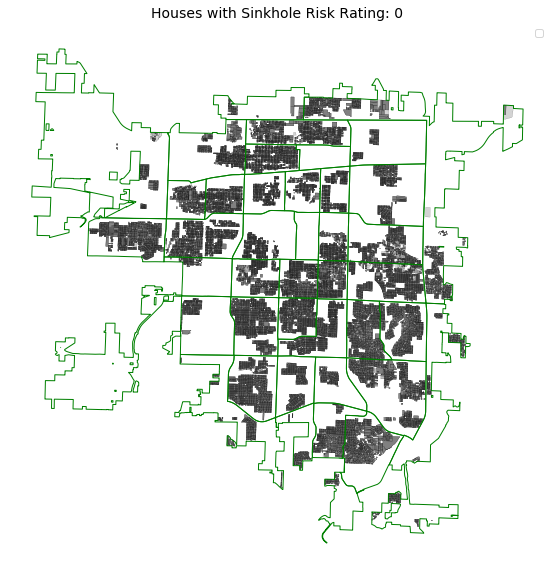

No handles with labels found to put in legend.


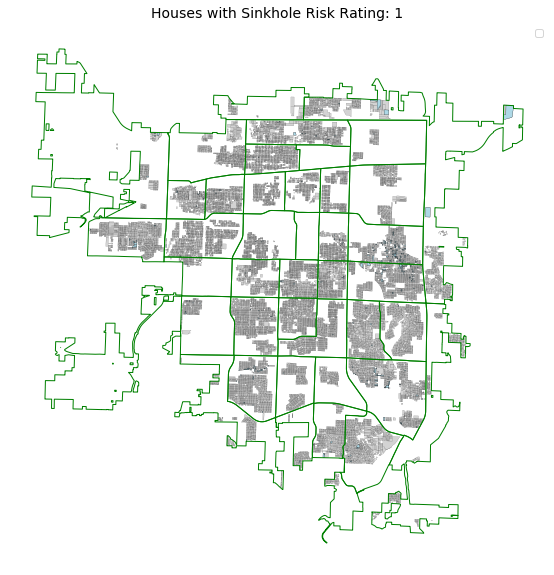

No handles with labels found to put in legend.


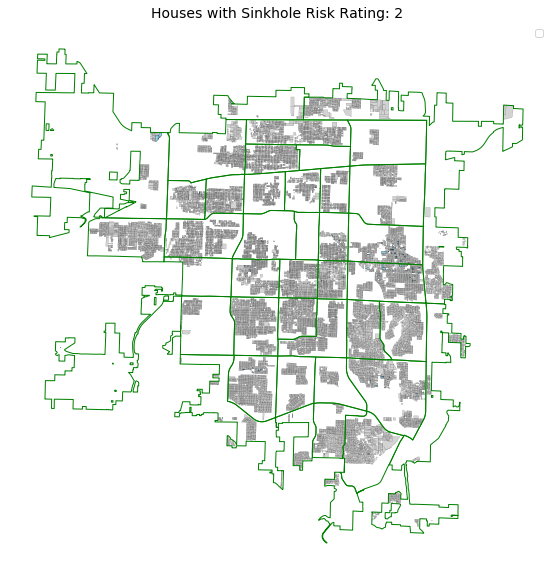

No handles with labels found to put in legend.


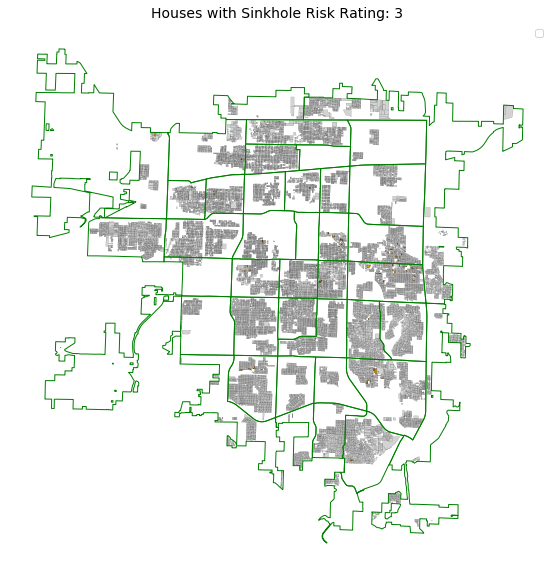

No handles with labels found to put in legend.


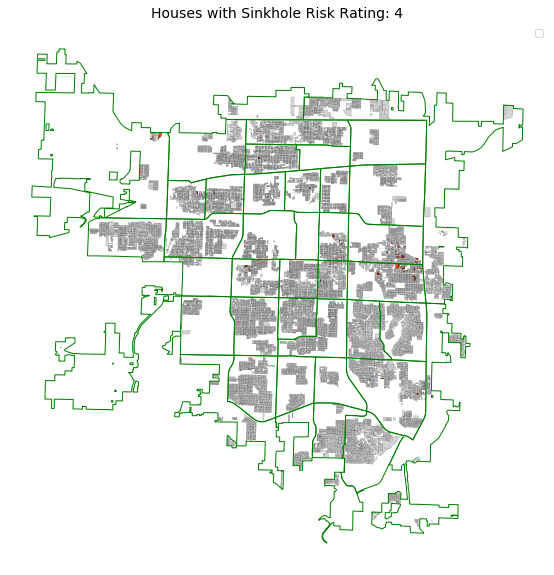

No handles with labels found to put in legend.


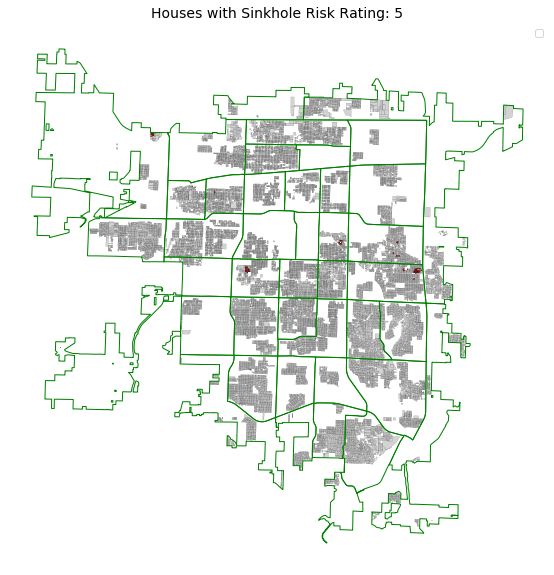

In [110]:
# Filter parcels with houses
parcels_with_houses = result[result['has_house'] == 'Y']

# Unique risk ratings (e.g., 0 to 5)
risk_levels = sorted(parcels_with_houses['sinkhole_house_risk_rating'].unique())

# Color map for each rating 
color_map = {
    0: 'gray',
    1: 'lightblue',
    2: 'skyblue',
    3: 'orange',
    4: 'orangered',
    5: 'red'
}

# Plot each risk level separately
for rating in risk_levels:
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Background: all houses in light gray
    parcels_with_houses.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.1)
    
    # Highlight parcels with current rating
    rating_subset = parcels_with_houses[parcels_with_houses['sinkhole_house_risk_rating'] == rating]
    rating_subset.plot(ax=ax, color=color_map.get(rating, 'blue'), edgecolor='black', linewidth=0.2, label=f'Risk Rating {rating}')
    
    # Overlay NSA boundaries
    nsa.plot(ax=ax, color='none', edgecolor='green', linewidth=1, label='NSA Boundaries')
    
    # Final formatting
    ax.set_title(f"Houses with Sinkhole Risk Rating: {rating}", fontsize=14)
    ax.axis('off')
    ax.legend()
    
    plt.show()


In [111]:
# filter only the nsa that has highest number of houses with sinkhole impact
filtered_df = result[result['NSA'].isin(['BINGHAM', 'OAK GROVE'])]


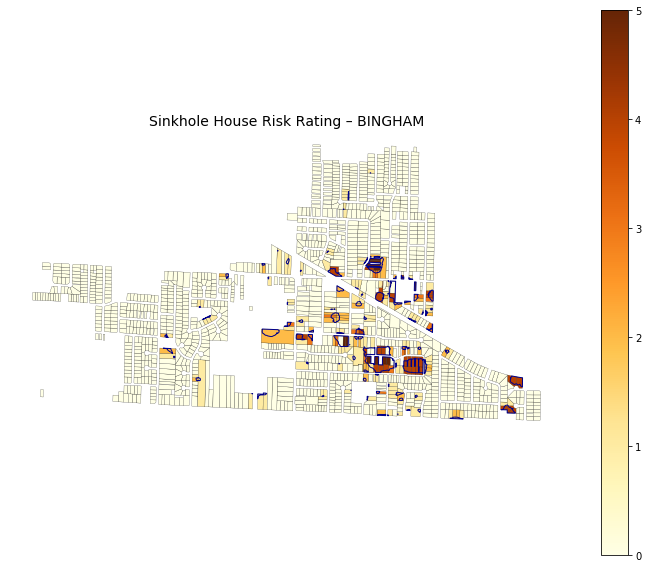

In [112]:


# Filter BINGHAM NSA
bingham_df = filtered_df[filtered_df['NSA'] == 'BINGHAM']
bingham_df = bingham_df.to_crs(sinkholes.crs)

# Combine BINGHAM polygons into one multipolygon
bingham_geom = bingham_df.unary_union
if bingham_geom.geom_type == 'Polygon':
    bingham_geom = MultiPolygon([bingham_geom])

# Filter sinkholes that intersect with BINGHAM boundary
sinkholes_clipped = sinkholes[sinkholes.intersects(bingham_geom)].copy()

# Cut geometries to BINGHAM boundary
sinkholes_clipped['geometry'] = sinkholes_clipped['geometry'].intersection(bingham_geom)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot BINGHAM parcels with risk
bingham_df.plot(
    column='sinkhole_house_risk_rating',
    cmap='YlOrBr',
    legend=True,
    edgecolor='black',
    linewidth=0.2,
    ax=ax
)

# Overlay clipped sinkholes
sinkholes_clipped.plot(
    ax=ax,
    color='none',  # use 'none' not '' to skip fill
    edgecolor='darkblue',
    alpha=1,
    linewidth=1
)

ax.set_title('Sinkhole House Risk Rating – BINGHAM', fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


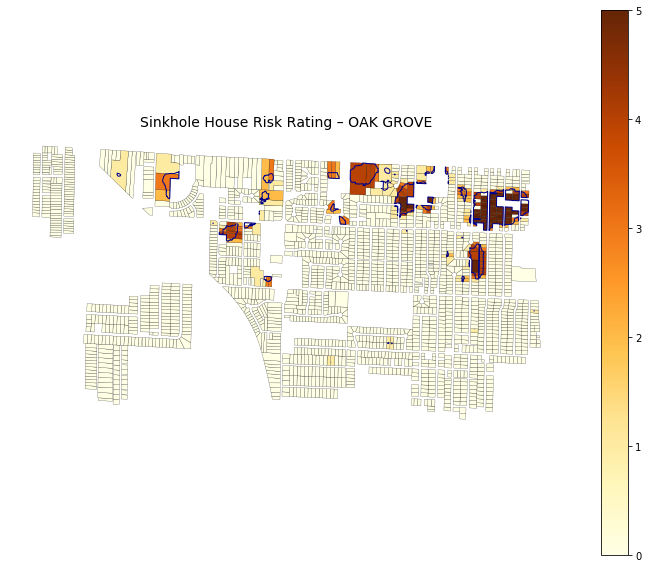

In [113]:
# Filter OAK GROVE NSA
oakgrove_df = filtered_df[filtered_df['NSA'] == 'OAK GROVE']
oakgrove_df = oakgrove_df.to_crs(sinkholes.crs)

# Combine OAK GROVE polygons into one multipolygon
oakgrove_geom = oakgrove_df.unary_union
if oakgrove_geom.geom_type == 'Polygon':
    oakgrove_geom = MultiPolygon([oakgrove_geom])

# Filter sinkholes that intersect with OAK GROVE boundary
sinkholes_clipped = sinkholes[sinkholes.intersects(oakgrove_geom)].copy()

# Cut geometries to OAK GROVE boundary
sinkholes_clipped['geometry'] = sinkholes_clipped['geometry'].intersection(oakgrove_geom)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot OAK GROVE parcels with risk
oakgrove_df.plot(
    column='sinkhole_house_risk_rating',
    cmap='YlOrBr',
    legend=True,
    edgecolor='black',
    linewidth=0.2,
    ax=ax
)

# Overlay clipped sinkholes
sinkholes_clipped.plot(
    ax=ax,
    color='none',  # use 'none' to skip fill
    edgecolor='darkblue',
    alpha=1,
    linewidth=1
)

ax.set_title('Sinkhole House Risk Rating – OAK GROVE', fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

In [114]:
#add risk labels
risk_labels = {
    0: 'No Risk',
    1: 'Very Low Risk',
    2: 'Low Risk',
    3: 'Moderate Risk',
    4: 'High Risk',
    5: 'Severe Risk'
}

result['risk_label'] = result['sinkhole_house_risk_rating'].map(risk_labels)


In [115]:
#check structure
result.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 89486 entries, 0 to 89485
Data columns (total 71 columns):
FID                           89486 non-null int64
area_sq_m                     89486 non-null float64
OBJECTID_1                    43213 non-null float64
Join_Count                    43213 non-null float64
TARGET_FID                    43213 non-null float64
OBJECTID                      43213 non-null float64
PRIM_NUM                      43213 non-null object
SUB_NUM                       4 non-null object
PRE_DIR                       43213 non-null object
STR_NAM                       43213 non-null object
STR_TYPE                      43210 non-null object
CITY                          43213 non-null object
STATE                         43213 non-null object
ZIP5                          43213 non-null object
ADDRESS                       43213 non-null object
BLOCK                         43213 non-null object
NSA                           43213 non-null object

In [116]:
#Create the connection and extract data from 'springfield_final_dataset' table
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql.dsa.lan',
                            password=mypasswd)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# === Load full table  ===
query = "SELECT * FROM springfield_final_dataset;"
df = pd.read_sql(query, conn)
conn.close()

# ===  Identify all geometry columns ===
geometry_cols = [col for col in df.columns if 'geolocation' in col]

# ===  Convert all geometry columns from WKB to Shapely Points ===
from shapely import wkb

def safe_parse(val):
    try:
        if isinstance(val, str):
            return wkb.loads(val, hex=True)
        elif isinstance(val, (bytes, memoryview)):
            return wkb.loads(val)
    except:
        return None

for col in geometry_cols:
    df[col] = df[col].apply(safe_parse)

# ===  Wrap as GeoDataFrame using one geometry column ===
df_full = gpd.GeoDataFrame(df, geometry='home_geolocation', crs='EPSG:26915')

df_full.head()

I am able to connect to the database


,home_geolocation,block_group_id,address,objectid,zip5,nsa,bds_zone,zoning,drive_time_fire,drive_distance_fire,...,occupancy_consistency,housing_chg_20_22,occupancy_chg_20_22,pct_value_chg_20_22,house_price,bedrooms,bathrooms,square_footage,lot_size,year_built
0,POINT (478828.036 4106430.367),1500000US290770040021,2840 E TARA CT,109976,65804,ZONE4,C,R-SF,1.53,0.43,...,own_occ_pos,No Change or No Units,Ownership Increase,14.52,368495.199053,5,4,1706,17855.0,1983
1,POINT (478863.082 4106437.207),1500000US290770040021,2846 E TARA CT,109977,65804,ZONE4,C,R-SF,1.53,0.43,...,own_occ_pos,No Change or No Units,Ownership Increase,14.52,333961.627714,5,3,1173,18280.0,2009
2,POINT (478890.412 4106437.067),1500000US290770040021,2852 E TARA CT,107290,65804,ZONE4,C,R-SF,1.53,0.43,...,own_occ_pos,No Change or No Units,Ownership Increase,14.52,358686.215774,5,5,3367,15016.0,1991
3,POINT (478920.588 4106437.843),1500000US290770040021,2856 E TARA CT,55192,65804,ZONE4,C,R-SF,1.23,0.43,...,own_occ_pos,No Change or No Units,Ownership Increase,14.52,346362.075920,3,2,2481,15586.0,2000
4,POINT (478953.800 4106446.339),1500000US290770040021,5920 S BELGRAVIA AVE,88558,65804,ZONE4,C,R-SF,1.23,0.43,...,own_occ_pos,No Change or No Units,Ownership Increase,14.52,359821.771482,2,5,1627,21441.0,1974


In [117]:
#check shape
df_full.shape

(43388, 89)

In [118]:
#  Rename 'ADDRESS' to 'address' in result for joining
result_renamed = result.rename(columns={'ADDRESS': 'address'})

#  Merge the 4 columns directly into df_full
df_full = df_full.merge(
    result_renamed[['address', 'sinkhole_house_risk_rating', 'risk_label', 'has_sinkhole_impact']],
    on='address',
    how='inner'
)


In [119]:
#Check sample
df_full.head()

,home_geolocation,block_group_id,address,objectid,zip5,nsa,bds_zone,zoning,drive_time_fire,drive_distance_fire,...,pct_value_chg_20_22,house_price,bedrooms,bathrooms,square_footage,lot_size,year_built,sinkhole_house_risk_rating,risk_label,has_sinkhole_impact
0,POINT (478828.036 4106430.367),1500000US290770040021,2840 E TARA CT,109976,65804,ZONE4,C,R-SF,1.53,0.43,...,14.52,368495.199053,5,4,1706,17855.0,1983,0,No Risk,N
1,POINT (478863.082 4106437.207),1500000US290770040021,2846 E TARA CT,109977,65804,ZONE4,C,R-SF,1.53,0.43,...,14.52,333961.627714,5,3,1173,18280.0,2009,0,No Risk,N
2,POINT (478890.412 4106437.067),1500000US290770040021,2852 E TARA CT,107290,65804,ZONE4,C,R-SF,1.53,0.43,...,14.52,358686.215774,5,5,3367,15016.0,1991,0,No Risk,N
3,POINT (478920.588 4106437.843),1500000US290770040021,2856 E TARA CT,55192,65804,ZONE4,C,R-SF,1.23,0.43,...,14.52,346362.075920,3,2,2481,15586.0,2000,0,No Risk,N
4,POINT (478953.800 4106446.339),1500000US290770040021,5920 S BELGRAVIA AVE,88558,65804,ZONE4,C,R-SF,1.23,0.43,...,14.52,359821.771482,2,5,1627,21441.0,1974,0,No Risk,N


In [120]:
#check shape
df_full.shape

(43175, 92)

In [121]:
#check structure
df_full.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 43175 entries, 0 to 43174
Data columns (total 92 columns):
home_geolocation                              43175 non-null geometry
block_group_id                                43175 non-null object
address                                       43175 non-null object
objectid                                      43175 non-null int64
zip5                                          43175 non-null int64
nsa                                           43175 non-null object
bds_zone                                      43175 non-null object
zoning                                        43175 non-null object
drive_time_fire                               43166 non-null float64
drive_distance_fire                           43166 non-null float64
feature_geolocation_fire                      43166 non-null object
feature_address_fire                          43166 non-null object
feature_category_fire                         43166 non-null obje

In [122]:
# Filter the incorrect records
invalid_records = df_full[
    (df_full['has_sinkhole_impact'] == 'N') & 
    (df_full['sinkhole_house_risk_rating'] != 0)
]

# Select the required columns
columns_to_extract = [
    'address',
    'home_geolocation',
    'nsa',
    'sinkhole_house_risk_rating',
    'risk_label',
    'has_sinkhole_impact'
]

# Extract and display
invalid_records = invalid_records[columns_to_extract]
invalid_records


,address,home_geolocation,nsa,sinkhole_house_risk_rating,risk_label,has_sinkhole_impact
344,5189 S HAZEL DR,POINT (474711.211 4108190.606),ZONE4,1,Very Low Risk,N
349,1923 E CANTERBURY ST,POINT (476857.745 4108193.980),LAKE SGF,1,Very Low Risk,N
534,5043 S PRISTINE CT,POINT (476772.056 4108395.996),LAKE SGF,1,Very Low Risk,N
592,1937 E NORSHIRE ST,POINT (476862.155 4108441.203),LAKE SGF,1,Very Low Risk,N
783,4960 S PALMER AVE,POINT (475999.223 4108603.056),SOUTHSIDE,1,Very Low Risk,N
...,...,...,...,...,...,...
41175,2262 E LIVINGSTON ST,POINT (477847.294 4122071.844),PARKWOOD,1,Very Low Risk,N
41190,2623 N PIERCE AVE,POINT (474937.726 4122089.238),DOLING PK,1,Very Low Risk,N
41567,646 E LIVINGSTON ST,POINT (474819.454 4122230.487),DOLING PK,1,Very Low Risk,N
42742,5052 E FR104,POINT (483559.235 4122987.596),ZONE2,1,Very Low Risk,N


In [123]:
# Filter the 'result' DataFrame using those addresses
invalid_addresses = invalid_records['address']
final_output = result[result['ADDRESS'].isin(invalid_addresses)][[
    'NSA', 'ADDRESS', 'ploccshpct', 'inter_area', 'has_house'
]]

# Display the result
final_output

,NSA,ADDRESS,ploccshpct,inter_area,has_house
389,ZONE4,5189 S HAZEL DR,0.0,4.454,Y
394,LAKE SGF,1923 E CANTERBURY ST,0.0,1.546,Y
578,LAKE SGF,5043 S PRISTINE CT,0.0,0.798,Y
636,LAKE SGF,1937 E NORSHIRE ST,0.0,2.938,Y
825,SOUTHSIDE,4960 S PALMER AVE,0.0,2.478,Y
...,...,...,...,...,...
41228,DOLING PK,2623 N PIERCE AVE,0.0,2.452,Y
41605,DOLING PK,646 E LIVINGSTON ST,0.0,2.714,Y
42780,ZONE2,5052 E FR104,0.0,71.809,Y
42886,ZONE2,3254 N DELAWARE AVE,1.0,6.167,Y


# update the final dataset we created in part one with sinkhole risk attributes

In [ ]:
#connect to PostgreSQL

database = "f24t03"
user = "jsmm8"
host = "pgsql.dsa.lan"
engine = create_engine(f'postgresql+psycopg2://{user}:{mypasswd}@{host}/{database}')
conn = psycopg2.connect(database=database, user=user, host=host, password=mypasswd)
cursor = conn.cursor()

cursor.execute("""
DROP TABLE IF EXISTS georealedge_data;

CREATE TABLE georealedge_data AS
SELECT * FROM springfield_final_dataset;
""")
conn.commit()
print("georealedge_data created with data copied from springfield_final_dataset.")


georealedge_data created with data copied from springfield_final_dataset.


In [125]:
#check count of records
cursor.execute("SELECT COUNT(*) FROM georealedge_data;")
count = cursor.fetchone()[0]
print(f"georealedge_data contains {count} records.")


georealedge_data contains 43388 records.


In [126]:
#alter table to add these sinkhole risk columns
cursor.execute("""
ALTER TABLE georealedge_data
ADD COLUMN sinkhole_house_risk_rating INTEGER,
ADD COLUMN sinkhole_risk_label TEXT,
ADD COLUMN has_sinkhole_impact TEXT;
""")
conn.commit()


In [127]:
#update the table to load them with sinkhole risk data
update_sql = """
UPDATE georealedge_data
SET 
    sinkhole_house_risk_rating = %s,
    sinkhole_risk_label = %s,
    has_sinkhole_impact = %s
WHERE address = %s;
"""

update_count = 0

for _, row in df_full.iterrows():
    address = row['address']
    risk = row['sinkhole_house_risk_rating']
    label = row['risk_label']
    impact = row['has_sinkhole_impact']

    cursor.execute(update_sql, (risk, label, impact, address))
    if cursor.rowcount > 0:
        update_count += cursor.rowcount

conn.commit()
#get updated records count
print(f" {update_count} rows updated in `georealedge_data` directly from DataFrame.")


 43287 rows updated in `georealedge_data` directly from DataFrame.


In [128]:
#Check if there are any records that has null values in these sinkhole columns
cursor.execute("""
    SELECT COUNT(*) 
    FROM georealedge_data
    WHERE sinkhole_house_risk_rating IS NULL
      AND sinkhole_risk_label IS NULL
      AND has_sinkhole_impact IS NULL;
""")
null_count = cursor.fetchone()[0]
print(f" {null_count} records have all 3 sinkhole columns as NULL in `georealedge_data`.")


 247 records have all 3 sinkhole columns as NULL in `georealedge_data`.


In [130]:
#delete the null records
cursor.execute("""
    DELETE FROM georealedge_data
    WHERE sinkhole_house_risk_rating IS NULL
      AND sinkhole_risk_label IS NULL
      AND has_sinkhole_impact IS NULL;
""")
conn.commit()


In [132]:
#check structure of table
cursor.execute("""
    SELECT column_name, data_type 
    FROM information_schema.columns
    WHERE table_name = 'georealedge_data'
    ORDER BY ordinal_position;
""")

columns = cursor.fetchall()
print("Structure of `georealedge_data` table:")
for col in columns:
    print(f"- {col[0]}: {col[1]}")


Structure of `georealedge_data` table:
- home_geolocation: USER-DEFINED
- block_group_id: text
- address: text
- objectid: integer
- zip5: integer
- nsa: text
- bds_zone: text
- zoning: text
- drive_time_fire: double precision
- drive_distance_fire: double precision
- feature_geolocation_fire: USER-DEFINED
- feature_address_fire: text
- feature_category_fire: text
- drive_time_police: double precision
- drive_distance_police: double precision
- feature_geolocation_police: USER-DEFINED
- feature_address_police: text
- feature_category_police: text
- drive_time_early_childhood_school: double precision
- drive_distance_early_childhood_school: double precision
- feature_geolocation_early_childhood_school: USER-DEFINED
- feature_address_early_childhood_school: text
- feature_category_early_childhood_school: text
- drive_time_elementary_school: double precision
- drive_distance_elementary_school: double precision
- feature_geolocation_elementary_school: USER-DEFINED
- feature_address_element

In [133]:
#grant privileges to table springfield_final_dataset

grant_privileges_query = "GRANT ALL PRIVILEGES ON TABLE georealedge_data TO jsmm8, remcmf, sgdky;"

with engine.connect() as connection:
        connection.execute(text(grant_privileges_query))
        print("Privileges granted successfully.")

Privileges granted successfully.


# sinkhole EDA

In [134]:
#Create the connection and extract data from 'georealedge_data' table again
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql.dsa.lan',
                            password=mypasswd)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# ===  Load full table  ===
query = "SELECT * FROM georealedge_data;"
df = pd.read_sql(query, conn)
conn.close()

# ===  Identify all geometry columns ===
geometry_cols = [col for col in df.columns if 'geolocation' in col]

# === Convert all geometry columns from WKB to Shapely Points ===


def safe_parse(val):
    try:
        if isinstance(val, str):
            return wkb.loads(val, hex=True)
        elif isinstance(val, (bytes, memoryview)):
            return wkb.loads(val)
    except:
        return None

for col in geometry_cols:
    df[col] = df[col].apply(safe_parse)

# ===  Wrap as GeoDataFrame using one geometry column ===
df_full = gpd.GeoDataFrame(df, geometry='home_geolocation', crs='EPSG:26915')

df_full.head()

I am able to connect to the database


,home_geolocation,block_group_id,address,objectid,zip5,nsa,bds_zone,zoning,drive_time_fire,drive_distance_fire,...,pct_value_chg_20_22,house_price,bedrooms,bathrooms,square_footage,lot_size,year_built,sinkhole_house_risk_rating,sinkhole_risk_label,has_sinkhole_impact
0,POINT (473920.382 4107169.065),1500000US290770040032,5721 S JEFFERSON AVE,93520,65810,ZONE3,BS,R-SF,NaN,NaN,...,27.67,255734.129457,1,2,3492,15994.0,1982,0,No Risk,N
1,POINT (473921.427 4107193.853),1500000US290770040032,5707 S JEFFERSON AVE,64936,65810,ZONE3,BS,R-SF,NaN,NaN,...,27.67,217427.136628,2,3,2400,13921.0,1972,0,No Risk,N
2,POINT (473921.978 4107218.153),1500000US290770040032,5693 S JEFFERSON AVE,64935,65810,ZONE3,BS,R-SF,NaN,NaN,...,27.67,252728.906889,4,5,2315,21898.0,1989,0,No Risk,N
3,POINT (473922.733 4107242.465),1500000US290770040032,5681 S JEFFERSON AVE,64934,65810,ZONE3,BS,R-SF,NaN,NaN,...,27.67,220516.603524,6,3,2206,15427.0,1966,0,No Risk,N
4,POINT (479745.719 4108329.243),1500000US290770038012,5032 S REVERE AVE,106813,65804,ZONE4,C,R-SF,NaN,NaN,...,31.83,764676.005510,5,4,2927,15234.0,1987,0,No Risk,N


In [136]:
# Group by 'has_sinkhole_impact' and count Sinkhole_House_Risk_Rating values
riskrating_by_impact = df_full.groupby('has_sinkhole_impact')['sinkhole_house_risk_rating'].value_counts()

# Display the result
print(riskrating_by_impact)


has_sinkhole_impact  sinkhole_house_risk_rating
N                    0                             42284
                     1                               143
Y                    1                               247
                     2                               124
                     3                               117
                     5                               114
                     4                               112
Name: sinkhole_house_risk_rating, dtype: int64


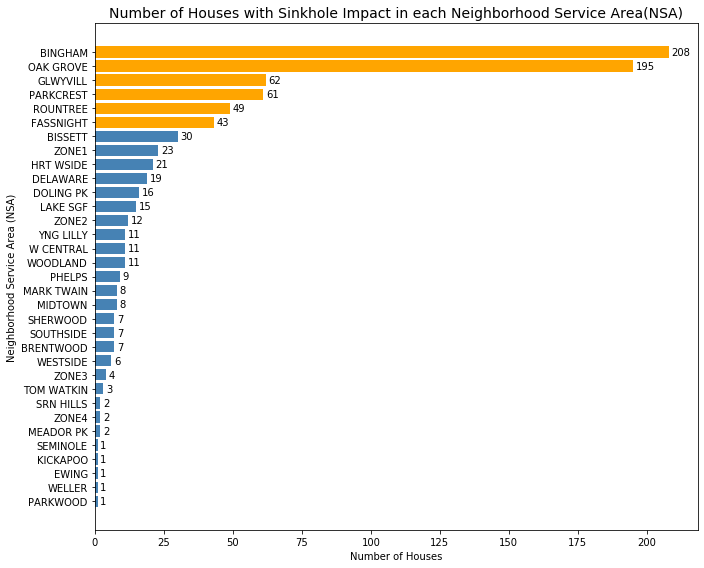

In [137]:
# Filter for houses with sinkhole impact
impact_data = df_full[df_full['sinkhole_house_risk_rating'] != 0]

# Group by NSA and count how many houses have sinkhole impact
nsa_impact_counts = impact_data['nsa'].value_counts().sort_values(ascending=True)

# Identify top 5 NSA names
top_5_nsas = nsa_impact_counts.sort_values(ascending=False).head(6).index.tolist()

# Assign colors: orange for top 5, steelblue for others
bar_colors = ['orange' if nsa in top_5_nsas else 'steelblue' for nsa in nsa_impact_counts.index]

# Plot horizontal bar chart
plt.figure(figsize=(10, 8))
bars = plt.barh(nsa_impact_counts.index, nsa_impact_counts.values, color=bar_colors)

# Add count labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, str(int(width)), va='center')

# Title and labels
plt.title("Number of Houses with Sinkhole Impact in each Neighborhood Service Area(NSA)", fontsize=14)
plt.xlabel("Number of Houses")
plt.ylabel("Neighborhood Service Area (NSA)")
plt.tight_layout()

plt.show()


In [138]:
#check impacted houses dataset shape
impact_data.shape

(857, 92)

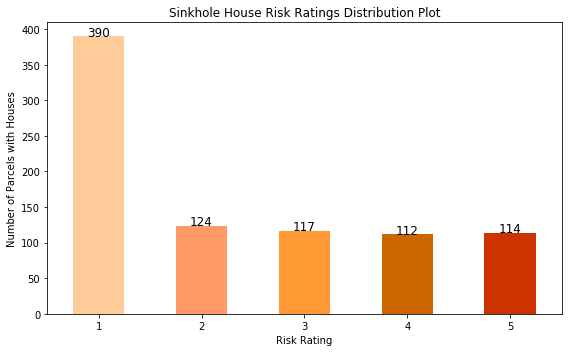

In [147]:

# Filter out risk rating = 0
filtered_df = df_full[df_full['sinkhole_house_risk_rating'] != 0]

# Count each risk rating
riskrating_counts = filtered_df['sinkhole_house_risk_rating'].value_counts().sort_index()

#  Define custom colors for risk ratings 1–5
custom_colors = ['#FFCC99', '#FF9966', '#FF9933', '#CC6600', '#CC3300']

#  Plot with custom colors
ax = riskrating_counts.plot(kind='bar', figsize=(8, 5), color=custom_colors)

# Labels and formatting
plt.title('Sinkhole House Risk Ratings Distribution Plot')
plt.xlabel('Risk Rating')
plt.ylabel('Number of Parcels with Houses')
plt.xticks(rotation=0)

#  Add values on top of bars
for i, val in enumerate(riskrating_counts):
    ax.text(i, val + 5, str(int(val)), ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()


# update the final dataset we created in part one with floodplain risk attributes


In [24]:
#Create the connection and extract data from 'floodplain_risk' table
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql.dsa.lan',
                            password=mypasswd)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# ===  Load full table  ===
query = "SELECT * FROM floodplain_risk;"
df = pd.read_sql(query, conn)
conn.close()

df.head()

I am able to connect to the database


,address,objectid,pct_fld_oc,has_floodplain_impact,floodplain_risk_rating,floodplain_risk_label
0,6525 S MEADOWVIEW AVE,4376,NaN,N,0,No Risk
1,6519 S MEADOWVIEW AVE,18394,NaN,N,0,No Risk
2,6513 S MEADOWVIEW AVE,79507,NaN,N,0,No Risk
3,6505 S MEADOWVIEW AVE,36663,NaN,N,0,No Risk
4,3454 E LADUE ST,27522,NaN,N,0,No Risk


In [25]:
#fill na values with 0 as in QGIS the output is NaN for no overlap of floodplain over parcel
df['pct_fld_oc'] = df['pct_fld_oc'].fillna(0)

In [26]:
#Check sample
df.head()

,address,objectid,pct_fld_oc,has_floodplain_impact,floodplain_risk_rating,floodplain_risk_label
0,6525 S MEADOWVIEW AVE,4376,0.0,N,0,No Risk
1,6519 S MEADOWVIEW AVE,18394,0.0,N,0,No Risk
2,6513 S MEADOWVIEW AVE,79507,0.0,N,0,No Risk
3,6505 S MEADOWVIEW AVE,36663,0.0,N,0,No Risk
4,3454 E LADUE ST,27522,0.0,N,0,No Risk


In [28]:
#check structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43189 entries, 0 to 43188
Data columns (total 6 columns):
address                   43189 non-null object
objectid                  43189 non-null int64
pct_fld_oc                43189 non-null float64
has_floodplain_impact     43189 non-null object
floodplain_risk_rating    43189 non-null int64
floodplain_risk_label     43189 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 2.0+ MB


In [29]:
#check risk rating counts
df['floodplain_risk_rating'].value_counts()

0    42803
1      112
2       91
4       80
3       68
5       35
Name: floodplain_risk_rating, dtype: int64

In [ ]:
#alter the table to add floodplain columns
database = "f24t03"
user = "jsmm8"
host = "pgsql.dsa.lan"
engine = create_engine(f'postgresql+psycopg2://{user}:{mypasswd}@{host}/{database}')
conn = psycopg2.connect(database=database, user=user, host=host, password=mypasswd)
cursor = conn.cursor()

cursor.execute("""
ALTER TABLE georealedge_data
ADD COLUMN pct_fld_oc DOUBLE PRECISION,
ADD COLUMN has_floodplain_impact TEXT,
ADD COLUMN floodplain_house_risk_rating INTEGER,
ADD COLUMN floodplain_risk_label TEXT;
""")
conn.commit()


In [12]:
#update the table with floodplain risk columns
update_sql = """
UPDATE georealedge_data
SET 
    pct_fld_oc = %s,
    has_floodplain_impact = %s,
    floodplain_house_risk_rating = %s,
    floodplain_risk_label = %s
WHERE address = %s;
"""

update_count = 0

for _, row in df.iterrows():
    address = row['address']
    percent = row['pct_fld_oc']
    impact = row['has_floodplain_impact']
    risk = row['floodplain_risk_rating']
    label = row['floodplain_risk_label']

    cursor.execute(update_sql, ( percent,impact,risk,label, address))
    if cursor.rowcount > 0:
        update_count += cursor.rowcount

conn.commit()
print(f" {update_count} rows updated in `georealedge_data` directly from DataFrame.")


 43165 rows updated in `georealedge_data` directly from DataFrame.


In [14]:
#Check for any null data in these flood plain columns
cursor.execute("""
    SELECT COUNT(*) 
    FROM georealedge_data
    WHERE has_floodplain_impact IS NULL
      AND floodplain_house_risk_rating IS NULL
      AND floodplain_risk_label IS NULL;
""")
null_count = cursor.fetchone()[0]
print(f" {null_count} records have all 4 floodplain columns as NULL in `georealedge_data`.")


 0 records have all 4 floodplain columns as NULL in `georealedge_data`.


In [18]:
#grant privileges to table springfield_final_dataset

grant_privileges_query = "GRANT ALL PRIVILEGES ON TABLE georealedge_data TO jsmm8, remcmf, sgdky;"

with engine.connect() as connection:
        connection.execute(text(grant_privileges_query))
        print("Privileges granted successfully.")

Privileges granted successfully.


In [3]:
#Create the connection and extract data from 'georealedge_data' table
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql.dsa.lan',
                            password=mypasswd)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

#  Load full table  ===
query = "SELECT * FROM georealedge_data;"
df = pd.read_sql(query, conn)
conn.close()

# === Identify all geometry columns ===
geometry_cols = [col for col in df.columns if 'geolocation' in col]

# ===  Convert all geometry columns from WKB to Shapely Points ===


def safe_parse(val):
    try:
        if isinstance(val, str):
            return wkb.loads(val, hex=True)
        elif isinstance(val, (bytes, memoryview)):
            return wkb.loads(val)
    except:
        return None

for col in geometry_cols:
    df[col] = df[col].apply(safe_parse)

#  Wrap as GeoDataFrame using one geometry column ===
df_full = gpd.GeoDataFrame(df, geometry='home_geolocation', crs='EPSG:26915')
#check sample
df_full.head()

I am able to connect to the database


,home_geolocation,block_group_id,address,objectid,zip5,nsa,bds_zone,zoning,drive_time_fire,drive_distance_fire,...,square_footage,lot_size,year_built,sinkhole_house_risk_rating,sinkhole_risk_label,has_sinkhole_impact,pct_fld_oc,has_floodplain_impact,floodplain_house_risk_rating,floodplain_risk_label
0,POINT (471174.694 4120899.099),1500000US290770033003,2511 W ATLANTIC ST,6720,65803,TOM WATKIN,A,R-SF,2.75,0.92,...,2358,10688.0,2019,0,No Risk,N,0.0,N,0,No Risk
1,POINT (472875.801 4120913.727),1500000US290770019001,2027 N JOHNSTON AVE,52747,65803,WOODLAND,A,R-SF,3.30,0.98,...,2947,19842.0,1971,0,No Risk,N,0.0,N,0,No Risk
2,POINT (473810.378 4120914.316),1500000US290770019002,2031 N LYON AVE,56844,65803,WOODLAND,BN,R-SF,1.89,0.54,...,3388,19634.0,1979,0,No Risk,N,0.0,N,0,No Risk
3,POINT (471548.433 4120914.286),1500000US290770033003,2014 N PARK AVE,38608,65803,TOM WATKIN,A,R-SF,3.17,1.14,...,2832,21306.0,2014,0,No Risk,N,0.0,N,0,No Risk
4,POINT (474571.749 4120917.463),1500000US290770055003,2040 N BENTON AVE,5218,65803,WOODLAND,BN,R-SF,3.22,0.92,...,2594,10017.0,1962,0,No Risk,N,0.0,N,0,No Risk


In [5]:
#check structure
df_full.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 43141 entries, 0 to 43140
Data columns (total 96 columns):
home_geolocation                              43141 non-null geometry
block_group_id                                43141 non-null object
address                                       43141 non-null object
objectid                                      43141 non-null int64
zip5                                          43141 non-null int64
nsa                                           43141 non-null object
bds_zone                                      43141 non-null object
zoning                                        43141 non-null object
drive_time_fire                               43132 non-null float64
drive_distance_fire                           43132 non-null float64
feature_geolocation_fire                      43132 non-null object
feature_address_fire                          43132 non-null object
feature_category_fire                         43132 non-null obje

In [6]:
#find flood plain risk rating counts
df_full['floodplain_house_risk_rating'].value_counts()

0    42751
1      112
2       91
4       80
3       72
5       35
Name: floodplain_house_risk_rating, dtype: int64

In [7]:
#find sinkhole risk rating counts
df_full['sinkhole_house_risk_rating'].value_counts()

0    42284
1      390
2      124
3      117
5      114
4      112
Name: sinkhole_house_risk_rating, dtype: int64

In [8]:
#check nsa house counts
df_full['nsa'].value_counts()

WESTSIDE      2315
MARK TWAIN    2229
OAK GROVE     2156
YNG LILLY     1994
PARKCREST     1937
GLWYVILL      1876
DOLING PK     1848
MEADOR PK     1770
WOODLAND      1712
BRENTWOOD     1568
ZONE2         1539
SEMINOLE      1520
BINGHAM       1512
PHELPS        1503
SRN HILLS     1355
HRT WSIDE     1278
LAKE SGF      1210
FASSNIGHT     1125
DELAWARE      1116
TOM WATKIN    1029
W CENTRAL      932
ROUNTREE       885
WELLER         882
COOPER PK      873
GRANT BCH      837
SOUTHSIDE      834
BISSETT        807
KICKAPOO       754
ZONE4          753
MIDTOWN        699
ZONE1          664
ZONE3          458
SHERWOOD       402
BRADFRD PK     333
PARKWOOD       281
EWING          155
Name: nsa, dtype: int64

In [10]:
#Create a stratified dataset for georealedge user interface data sample to work on demo

# Drop rows with missing values in the three stratifying columns
df_valid = df_full[
    df_full[['nsa', 'has_sinkhole_impact', 'has_floodplain_impact']].notnull().all(axis=1)
]

# Sampling function for each NSA group
def triple_stratified_sample(group):
    total_target = 100
    
    # Group by both sinkhole and floodplain impact
    strat_group = group.groupby(['has_sinkhole_impact', 'has_floodplain_impact'])
    
    # Count samples per subgroup
    subgroup_counts = strat_group.size().reset_index(name='count')
    
    if subgroup_counts.empty:
        return pd.DataFrame()
    
    # Determine proportions
    subgroup_counts['proportion'] = subgroup_counts['count'] / subgroup_counts['count'].sum()
    subgroup_counts['sample_size'] = (subgroup_counts['proportion'] * total_target).round().astype(int)
    
    sampled_rows = []
    
    for _, row in subgroup_counts.iterrows():
        y_n = row['has_sinkhole_impact']
        f_n = row['has_floodplain_impact']
        n_sample = row['sample_size']
        
        sub_df = group[
            (group['has_sinkhole_impact'] == y_n) &
            (group['has_floodplain_impact'] == f_n)
        ]
        
        if len(sub_df) == 0:
            continue
        
        sample = sub_df.sample(n=n_sample, replace=(len(sub_df) < n_sample), random_state=42)
        sampled_rows.append(sample)
    
    return pd.concat(sampled_rows)

# Apply the sampling to each NSA
df_final_sample = df_valid.groupby('nsa', group_keys=False).apply(triple_stratified_sample)

# Final shape and check
print(f"Total sampled records: {len(df_final_sample)}")
df_final_sample.groupby(['nsa', 'has_sinkhole_impact', 'has_floodplain_impact']).size().unstack(fill_value=0)


Total sampled records: 3600


has_floodplain_impact             N  Y
nsa        has_sinkhole_impact        
BINGHAM    N                     88  0
           Y                     12  0
BISSETT    N                     97  0
           Y                      3  0
BRADFRD PK N                    100  0
BRENTWOOD  N                    100  0
COOPER PK  N                     95  5
DELAWARE   N                     98  0
           Y                      2  0
DOLING PK  N                     98  1
           Y                      1  0
EWING      N                     99  1
FASSNIGHT  N                     95  1
           Y                      4  0
GLWYVILL   N                     97  0
           Y                      3  0
GRANT BCH  N                    100  0
HRT WSIDE  N                     98  0
           Y                      2  0
KICKAPOO   N                     99  1
LAKE SGF   N                     99  1
           Y                      1  0
MARK TWAIN N                     98  2
MEADOR PK  N                     95  5
MIDTOWN    N                     98  1
           Y                      1  0
OAK GROVE  N                     92  0
           Y                      8  0
PARKCREST  N                     98  0
           Y                      2  0
PARKWOOD   N                    100  0
PHELPS     N                     99  1
ROUNTREE   N                     95  0
           Y                      5  0
SEMINOLE   N                     99  1
SHERWOOD   N                     99  0
           Y                      1  0
SOUTHSIDE  N                    100  0
SRN HILLS  N                     98  2
TOM WATKIN N                    100  0
W CENTRAL  N                     99  0
           Y                      1  0
WELLER     N                     94  6
WESTSIDE   N                     99  1
WOODLAND   N                     99  0
           Y                      1  0
YNG LILLY  N                     99  1
ZONE1      N                     96  0
           Y                      3  0
ZONE2      N                     99  1
ZONE3      N                     97  2
           Y                      1  0
ZONE4      N                    100  0

In [11]:
# Overall count for sinkhole impact
print("Sinkhole Impact - Overall Distribution:")
print(df_final_sample['has_sinkhole_impact'].value_counts())

# Per NSA sinkhole impact houses
print("\nSinkhole Impact - Distribution per NSA:")
print(df_final_sample.groupby(['nsa'])['has_sinkhole_impact'].value_counts().unstack(fill_value=0))


Sinkhole Impact - Overall Distribution:
N    3549
Y      51
Name: has_sinkhole_impact, dtype: int64

Sinkhole Impact - Distribution per NSA:
has_sinkhole_impact    N   Y
nsa                         
BINGHAM               88  12
BISSETT               97   3
BRADFRD PK           100   0
BRENTWOOD            100   0
COOPER PK            100   0
DELAWARE              98   2
DOLING PK             99   1
EWING                100   0
FASSNIGHT             96   4
GLWYVILL              97   3
GRANT BCH            100   0
HRT WSIDE             98   2
KICKAPOO             100   0
LAKE SGF             100   1
MARK TWAIN           100   0
MEADOR PK            100   0
MIDTOWN               99   1
OAK GROVE             92   8
PARKCREST             98   2
PARKWOOD             100   0
PHELPS               100   0
ROUNTREE              95   5
SEMINOLE             100   0
SHERWOOD              99   1
SOUTHSIDE            100   0
SRN HILLS            100   0
TOM WATKIN           100   0
W CENTRAL         

In [12]:
# Overall count for floodplain impact
print("\nFloodplain Impact - Overall Distribution:")
print(df_final_sample['has_floodplain_impact'].value_counts())

# Per NSA floodplain impact houses
print("\nFloodplain Impact - Distribution per NSA:")
print(df_final_sample.groupby(['nsa'])['has_floodplain_impact'].value_counts().unstack(fill_value=0))



Floodplain Impact - Overall Distribution:
N    3567
Y      33
Name: has_floodplain_impact, dtype: int64

Floodplain Impact - Distribution per NSA:
has_floodplain_impact    N  Y
nsa                          
BINGHAM                100  0
BISSETT                100  0
BRADFRD PK             100  0
BRENTWOOD              100  0
COOPER PK               95  5
DELAWARE               100  0
DOLING PK               99  1
EWING                   99  1
FASSNIGHT               99  1
GLWYVILL               100  0
GRANT BCH              100  0
HRT WSIDE              100  0
KICKAPOO                99  1
LAKE SGF               100  1
MARK TWAIN              98  2
MEADOR PK               95  5
MIDTOWN                 99  1
OAK GROVE              100  0
PARKCREST              100  0
PARKWOOD               100  0
PHELPS                  99  1
ROUNTREE               100  0
SEMINOLE                99  1
SHERWOOD               100  0
SOUTHSIDE              100  0
SRN HILLS               98  2
TOM WATKIN  